In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

import jax.numpy as jnp
import jax.random as jrandom

from plnn.models.algebraic_pl import AlgebraicPL
from plnn.pl import plot_phi


In [2]:
seed = 1231412
rng = np.random.default_rng(seed=seed)

In [3]:
OUTDIR = "out"

In [4]:
SAVE_ANIMATION = True
DT0 = 0.01
SIGMA = 0.4

In [5]:
model, hyperparams = AlgebraicPL.make_model(
    key=jrandom.PRNGKey(0),
    dtype=jnp.float64,
    algebraic_phi_id="phi1",
    tilt_weights=[[1, 0],[0, 1]],
    tilt_bias=[0, 0],
    sigma=SIGMA,
    signal_type="sigmoid",
    nsigparams=4,
    dt0=DT0,
)

In [6]:
key = jrandom.PRNGKey(rng.integers(2**32))

ncells = 100
x0_val = (0.0, -0.5)
tfin = 20
burnin = 0.2
burnin_signal = (0, 1)
dtsave1 = 0.25
dtsave2 = 2.


# Define signal profile
if model.signal_type == 'jump':
    sigparams = [[5, 0, 1], [7, 0, 1]]
elif model.signal_type == 'sigmoid':
    sigparams = [[10, -1, 1, 0.5], [10, 3, -1, 0.25]]
else:
    raise RuntimeError()
sigparams = jnp.array(sigparams)

# Initial condition
key, subkey = jrandom.split(key, 2)
x0 = np.zeros([ncells, 2])
x0[:] = x0_val

# Simulate particles in the landscape
key, subkey = jrandom.split(key, 2)
ts_all, xs_all, sigs_all, ps_all = model.run_landscape_simulation(
    x0, tfin, [dtsave1, dtsave2], sigparams, subkey, 
    burnin=burnin
)

ts, ts_saved = ts_all
xs, xs_saved = xs_all
sigs, sigs_saved = sigs_all
ps, ps_saved = ps_all

In [7]:
from plnn.vectorfields import find_minima_along_tilt_trajectory
from plnn.vectorfields import check_minima_trajectories_for_bifurcations

minima = find_minima_along_tilt_trajectory(
    model, ps,
    ndivisions=20,
    n=10,
    tol=1e-1,
    x0_range=[[-4,4],[-4,4]],
    method="BFGS",
    opt_tol=1e-5,
)

bifs, bif_idxs, bif_tilts, bif_mins = check_minima_trajectories_for_bifurcations(
    ps, minima
)

Identified 3 potential bifurcation points...
At time t=5.25:
	tau=(-0.983, 2.66)
	mins0:
		[ 0.12874661 -0.94595564]
	mins1:
		[ 0.12890549 -0.94008575]
		[1.12140298 0.51975426]
At time t=9.0:
	tau=(-0.462, 1.49)
	mins0:
		[ 0.07755233 -0.74185525]
		[1.26178238 0.75026726]
	mins1:
		[ 0.06255666 -0.7141107 ]
		[1.25925569 0.75729008]
		[-1.00527111  0.54984455]
At time t=10.75:
	tau=(0.358, 0.629)
	mins0:
		[-0.10937039 -0.40359602]
		[-1.33997299  0.8643343 ]
		[1.22401155 0.78569877]
	mins1:
		[-1.36327789  0.88689147]
		[1.21956567 0.79103545]
Starting points for potential bifurcations:
 [[ 0.12874661 -0.94595564]
 [ 0.12890549 -0.94008575]
 [ 1.12140298  0.51975426]
 [ 0.07755233 -0.74185525]
 [ 1.26178238  0.75026726]
 [ 0.06255666 -0.7141107 ]
 [ 1.25925569  0.75729008]
 [-1.00527111  0.54984455]
 [-0.10937039 -0.40359602]
 [-1.33997299  0.8643343 ]
 [ 1.22401155  0.78569877]
 [-1.36327789  0.88689147]
 [ 1.21956567  0.79103545]]


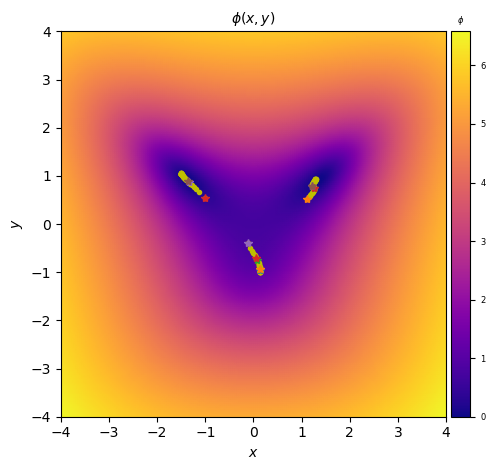

In [8]:
fig, ax = plt.subplots(1, 1)

print(f"Identified {len(bif_idxs)} potential bifurcation points...")
for i in range(len(bif_idxs)):
    tau0, tau1 = bif_tilts[i]
    mins0, mins1 = bif_mins[i]
    print(f"At time t={ts[bif_idxs[i]]}:")
    print(f"\ttau=({', '.join([f'{x:.3g}' for x in tau0])})")
    print(f"\tmins0:")
    for m in mins0:
        print(f"\t\t{m}")
    print(f"\tmins1:")
    for m in mins1:
        print(f"\t\t{m}")

plot_phi(
    model,
    tilt=[0,0],
    res=200,
    equal_axes=True,
    ax=ax,
    show=True,
)

for i in range(len(minima)):
    ax.plot(minima[i][:,0], minima[i][:,1], '.y');

for minset in bif_mins:
    for min in minset:
        ax.plot(min[:,0], min[:,1], '*');

print(f"Starting points for potential bifurcations:\n", bifs)

In [9]:
from cont.binary_choice import get_binary_choice_curves

bifseed1 = rng.integers(2**32)
bifseed2 = rng.integers(2**32)

landscape_tex = "$\phi$"

# bifcurves, bifcolors = get_plnn_bifurcation_curves(
#     model, 
#     xstarts=[[x, 'r'] for x in bifs],
#     xlims=[-2,2], ylims=[-2,2],
#     num_starts=50,
#     p1lims=[-2,2], p2lims=[-0.75,3],
#     seed=bifseed1,
#     color='r',
#     verbosity=0,
# )

bifcurves, bifcolors = get_binary_choice_curves(seed=0)


# Filter out singleton bifurcation curves and remove initial estimate point
keepidxs = [i for i in range(len(bifcurves)) if len(bifcurves[i]) > 1]
bifcurves = [bc[1:] for bc in bifcurves if len(bc) > 1]
bifcolors = [bifcolors[i] for i in keepidxs]


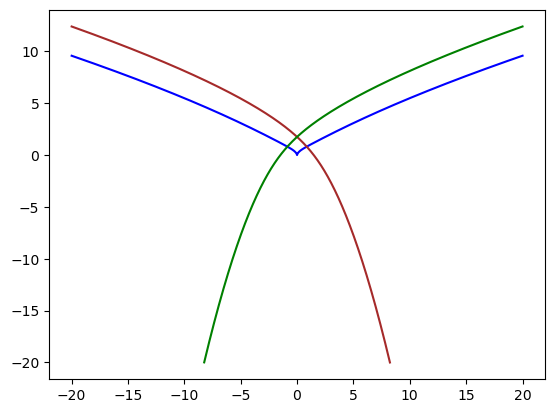

In [10]:
fig, ax = plt.subplots(1, 1)

for i in range(len(bifcurves)):
    curve = bifcurves[i]
    color = bifcolors[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-')

In [11]:
from plnn.helpers import get_phi1_fixed_points

fps, types, cols = get_phi1_fixed_points(ps)

In [12]:
for i, (fpset, typeset, colset, p) in enumerate(zip(fps, types, cols, ps)):
    print(i, p)
    for fp, t, c in zip(fpset, typeset, colset):
        print(fp, t, c)

0 [-0.9999092  2.9732286]
(0.125426487980307, -0.988643308714171) minimum blue
1 [-0.99988342  2.96969103]
(0.125480435892204, -0.988182422636310) minimum blue
2 [-0.99985031  2.96569006]
(0.125541088220419, -0.987660621480846) minimum blue
3 [-0.9998078   2.96116609]
(0.125609200858244, -0.987069921667775) minimum blue
4 [-0.99975321  2.95605223]
(0.125685591124044, -0.986401312294840) minimum blue
5 [-0.99968313  2.9502734 ]
(0.125771134639497, -0.985644628288861) minimum blue
6 [-0.99959315  2.94374549]
(0.125866758514292, -0.984788409403288) minimum blue
7 [-0.99947762  2.93637443]
(0.125973429386559, -0.983819743916679) minimum blue
8 [-0.9993293   2.92805516]
(0.126092134392193, -0.982724095928027) minimum blue
9 [-0.99913889  2.91867059]
(0.126223852512803, -0.981485115239803) minimum blue
10 [-0.99889444  2.90809052]
(0.126369512937308, -0.980084428986231) minimum blue
11 [-0.99858066  2.89617057]
(0.126529936009473, -0.978501414425228) minimum blue
12 [-0.9981779   2.88275108]

In [13]:
from plnn.data_generation.plnn_animator import PLNNSimulationAnimator
from plnn.data_generation.simulate import phi1_field

duration = 10
dpi = 200
grid_size = 1

animator = PLNNSimulationAnimator(
    model, sigparams,
    ts, xs, sigs, ps, 
    ts_saved, xs_saved, sigs_saved, ps_saved, 
    xlims=[-4, 4], ylims=[-4, 4],
    p0lims=[-2, 2],
    p1lims=[-1, 3],
    # minima=minima,
    fixed_point_info=(fps, types, cols),
    grad_func=lambda x, y, p: phi1_field(None, np.array([x, y]).T, p).T,
    bifcurves=bifcurves,
    bifcolors=bifcolors,
    view_init=(45, 30),
)

ani = animator.animate(
    duration=duration,
    dpi=dpi,
    grid_width=grid_size,
    grid_height=grid_size,
    suptitle="Example Dynamics in the Binary Choice Landscape"
)
plt.close()

Generating movie...
Finished in 0.995 seconds.


In [14]:
HTML(ani.to_html5_video())

Generating movie...
Finished in 0.915 seconds.
Saving animation to out/phi1_ani_demo


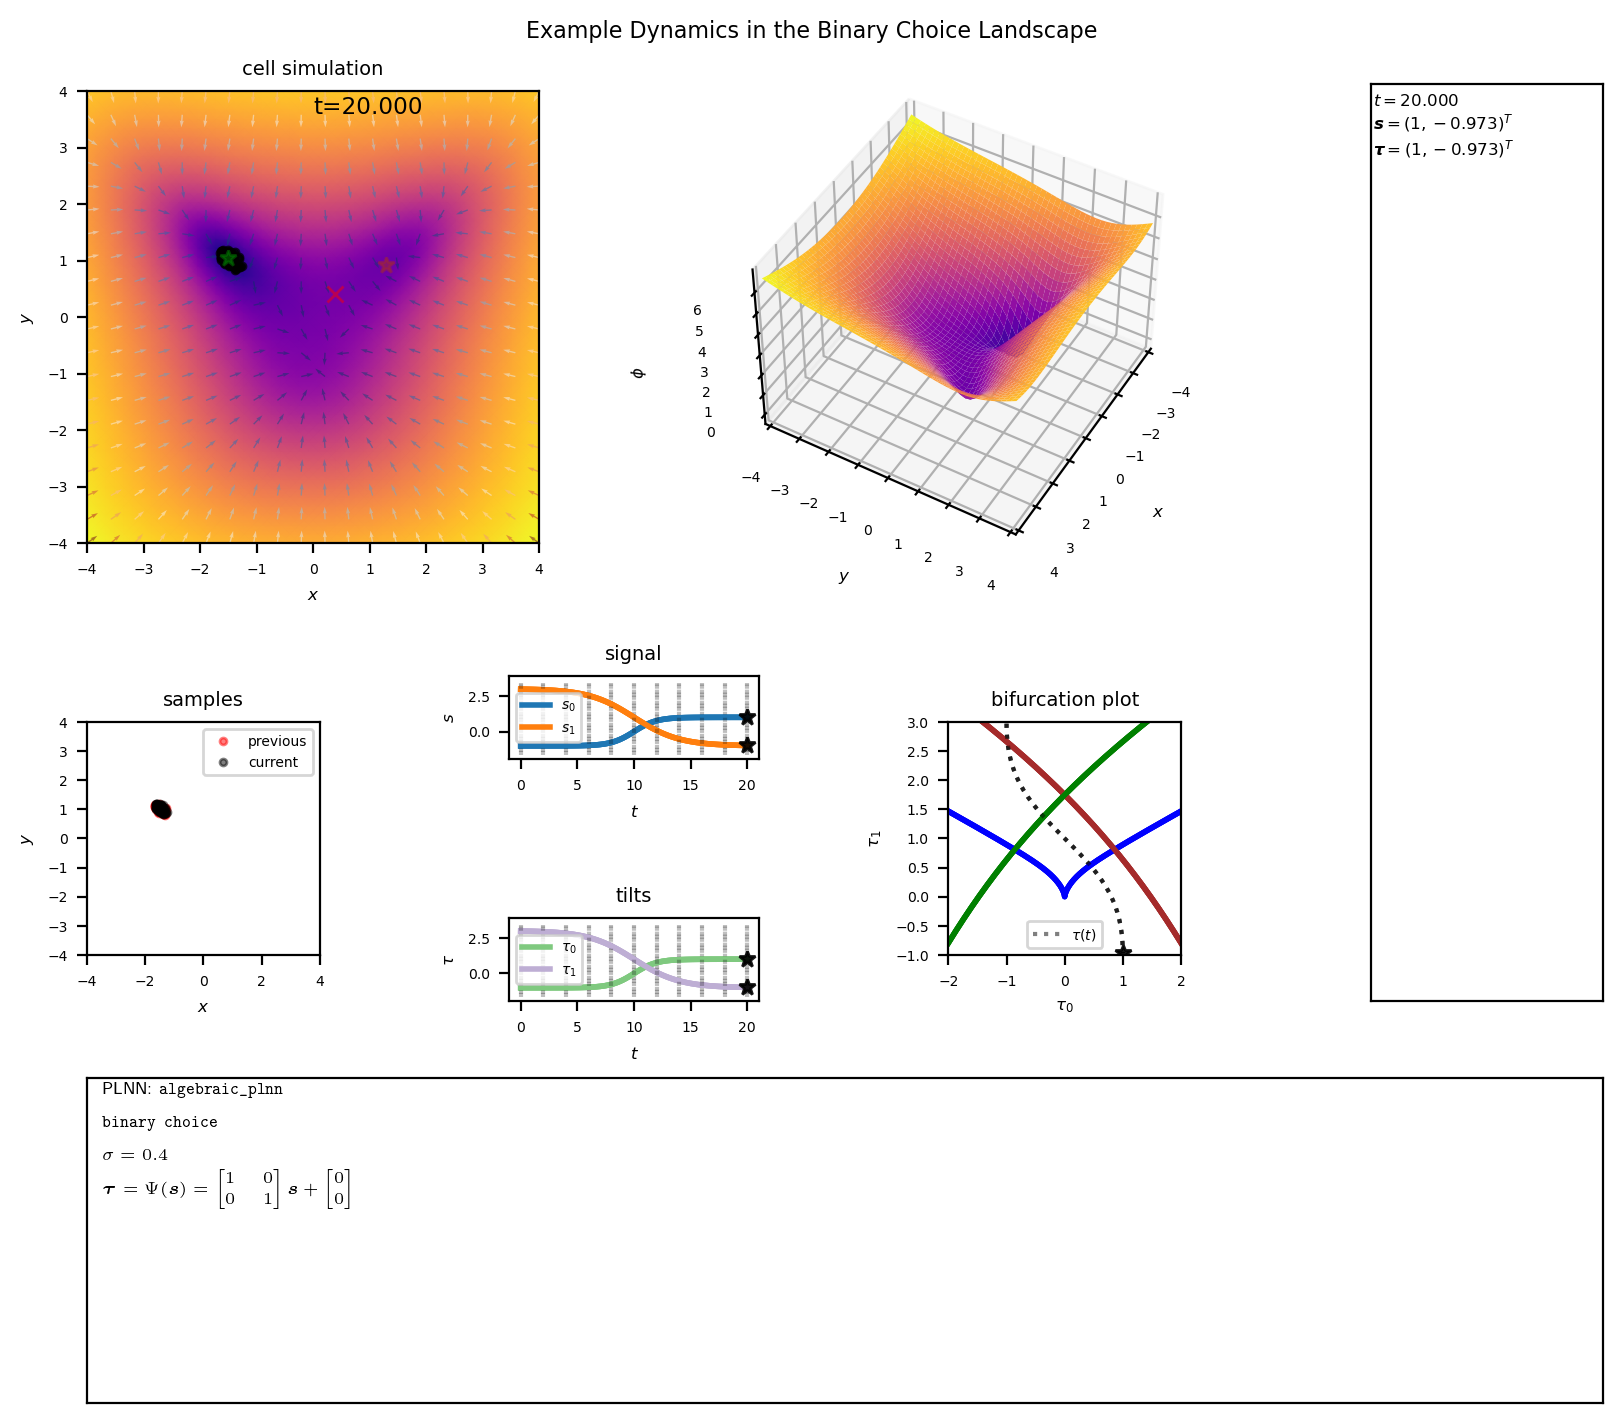

In [15]:
if SAVE_ANIMATION:
    ani = animator.animate(
        savepath=f"{OUTDIR}/phi1_ani_demo",
        saveas='mp4',
        duration=duration,
        dpi=dpi,
        grid_width=grid_size,
        grid_height=grid_size,
        suptitle="Example Dynamics in the Binary Choice Landscape"
    )

Generating movie...
Finished in 0.819 seconds.
Saving animation to out/phi1_ani_demo


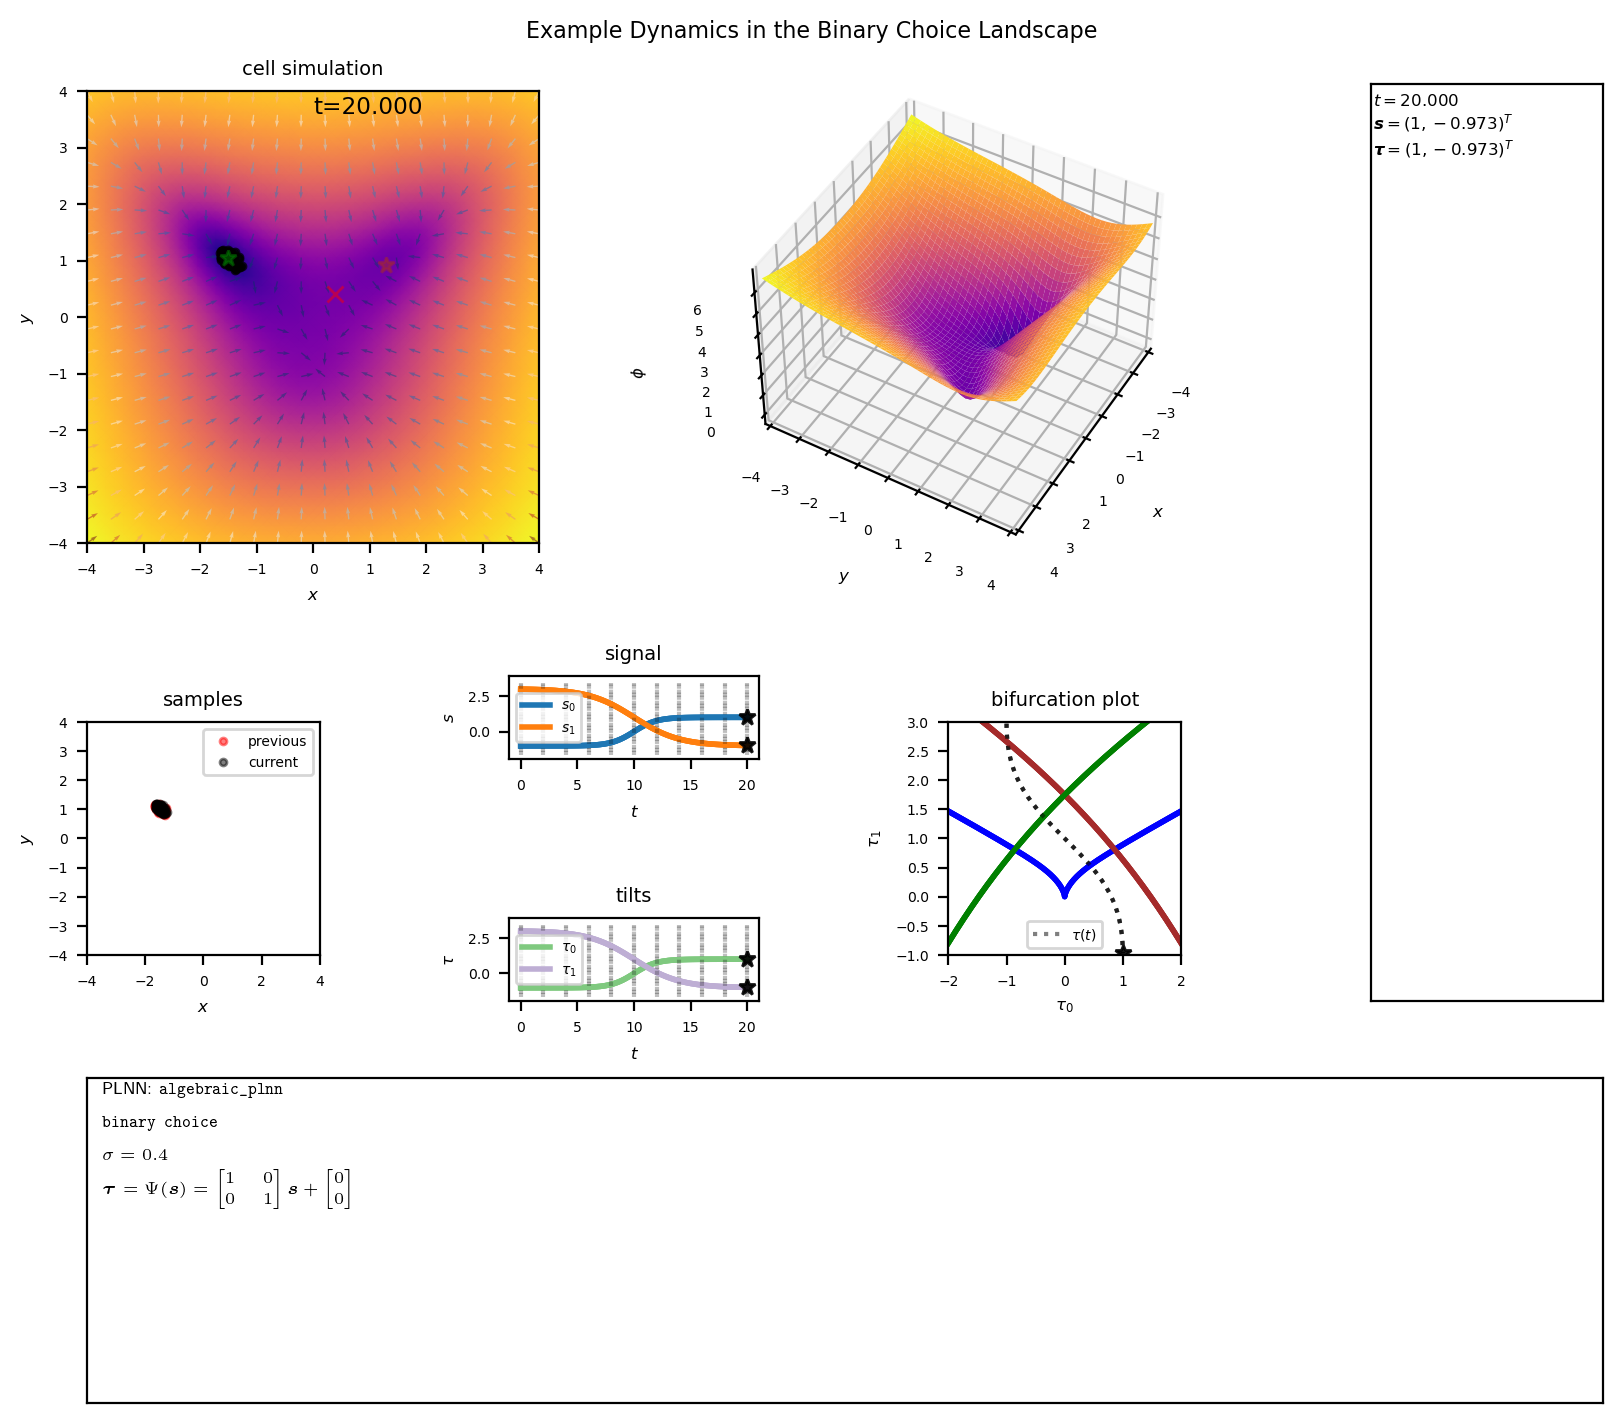

In [16]:
if SAVE_ANIMATION:
    ani = animator.animate(
        savepath=f"{OUTDIR}/phi1_ani_demo",
        saveas='gif',
        duration=duration,
        dpi=dpi,
        grid_width=grid_size,
        grid_height=grid_size,
        suptitle="Example Dynamics in the Binary Choice Landscape"
    )